In [ ]:
# Importing libraries

import ccxt
import json
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import datetime
import os

In [ ]:
import ccxt
import pandas as pd
import os

def filter_high_liquidity_pairs(exchange, min_volume=50000000):
    """Filters USDT pairs with high 24-hour trading volume."""
    try:
        markets = exchange.load_markets()
        return [s for s, data in markets.items() if "USDT" in s and float(data.get("info", {}).get("quoteVolume", 0)) > min_volume]
    except Exception as e:
        print(f"⚠️ Error fetching high-liquidity pairs: {e}")
        return []

def get_exchange_info(exchange_name, min_volume=50000000):
    """Fetch relevant trading information for a given exchange, filtering for high-liquidity USDT pairs."""
    try:
        exchange = getattr(ccxt, exchange_name)()

        # Fetch API rate limits
        rate_limits = {
            "rate_limit": exchange.rateLimit,
            "has_fetch_ticker": exchange.has["fetchTicker"],
            "has_fetch_balance": exchange.has["fetchBalance"],
            "has_fetch_order": exchange.has["fetchOrder"]
        }

        # Fetch trading fees (Spot)
        try:
            fees = exchange.fetch_trading_fees()
            trading_fees = {
                "maker_fee": fees.get("maker", 0.001),  # Default to 0.1% if unknown
                "taker_fee": fees.get("taker", 0.001)
            }
        except Exception:
            trading_fees = {"maker_fee": "Unknown", "taker_fee": "Unknown"}

        # Fetch supported symbols (Only high-liquidity USDT pairs)
        try:
            high_liquidity_symbols = filter_high_liquidity_pairs(exchange, min_volume)
        except Exception:
            high_liquidity_symbols = []

        return {
            "Exchange": exchange_name,
            "API Rate Limits": rate_limits,
            "Trading Fees": trading_fees,
            "Supported Symbols": high_liquidity_symbols
        }

    except Exception as e:
        return {"Error": f"⚠️ Could not retrieve data for {exchange_name}: {e}"}


def compare_fees_and_spreads(exchange1_name, exchange2_name, min_volume=50000000):
    """Compare trading fees, average cost, and spread for high-liquidity USDT trading pairs between two exchanges."""
    if exchange1_name == exchange2_name:
        raise ValueError("❌ Both exchanges are the same. Please enter two different exchanges.")

    if not hasattr(ccxt, exchange1_name) or not hasattr(ccxt, exchange2_name):
        raise ValueError("❌ One or both exchanges are not listed in CCXT. Check your inputs.")

    # Fetch exchange information
    exchange1_info = get_exchange_info(exchange1_name, min_volume)
    exchange2_info = get_exchange_info(exchange2_name, min_volume)

    # Find common trading symbols (Only high-liquidity USDT pairs)
    symbols1 = set(exchange1_info.get("Supported Symbols", []))
    symbols2 = set(exchange2_info.get("Supported Symbols", []))
    common_symbols = list(symbols1 & symbols2)

    print(f"✅ Found {len(common_symbols)} high-liquidity trading pairs between {exchange1_name} and {exchange2_name}")

    if not common_symbols:
        raise ValueError(f"❌ No common **high-liquidity** USDT trading pairs found between {exchange1_name} and {exchange2_name}.")

    # Connect to exchanges
    exchange1 = getattr(ccxt, exchange1_name)()
    exchange2 = getattr(ccxt, exchange2_name)()

    results = []

    for symbol in common_symbols:
        try:
            # Fetch latest prices
            price1 = exchange1.fetch_ticker(symbol)["last"]
            price2 = exchange2.fetch_ticker(symbol)["last"]

            # Calculate spread percentage
            spread = abs(price1 - price2) / ((price1 + price2) / 2) * 100

            # Get trading fees
            fee1 = exchange1_info["Trading Fees"]
            fee2 = exchange2_info["Trading Fees"]

            results.append({
                "Symbol": symbol,
                "Exchange 1": exchange1_name,
                "Exchange 2": exchange2_name,
                "Price 1": price1,
                "Price 2": price2,
                "Average Price": (price1 + price2) / 2,
                "Spread (%)": spread,
                "Exchange 1 Maker Fee": fee1["maker_fee"],
                "Exchange 1 Taker Fee": fee1["taker_fee"],
                "Exchange 2 Maker Fee": fee2["maker_fee"],
                "Exchange 2 Taker Fee": fee2["taker_fee"]
            })

        except Exception as e:
            print(f"⚠️ Error fetching data for {symbol}: {e}")
            continue  # Skip symbols that cause errors

    # Convert to a DataFrame for better visualization
    df = pd.DataFrame(results)
    
    if df.empty:
        raise ValueError("❌ No valid **high-liquidity** trading pairs with price data found.")

    return df


# Example Usage (Run only if results.csv does not exist)
if not os.path.exists('results.csv'):
    try:
        exchange1 = "binance"
        exchange2 = "bybit"
        result_df = compare_fees_and_spreads(exchange1, exchange2)

        # Display the results
        display(result_df)

    except ValueError as e:
        print(e)


565


,Symbol,Exchange 1,Exchange 2,Price 1,Price 2,Average Price,Spread (%),Exchange 1 Maker Fee,Exchange 1 Taker Fee,Exchange 2 Maker Fee,Exchange 2 Taker Fee
0,RENDER/USDT:USDT,binance,bybit,3.737000,3.735000,3.736000,0.053533,Unknown,Unknown,Unknown,Unknown
1,NOT/USDT,binance,bybit,0.002539,0.002538,0.002538,0.039393,Unknown,Unknown,Unknown,Unknown
2,VANRY/USDT,binance,bybit,0.032700,0.032740,0.032720,0.122249,Unknown,Unknown,Unknown,Unknown
3,MINA/USDT,binance,bybit,0.292200,0.292700,0.292450,0.170969,Unknown,Unknown,Unknown,Unknown
4,ORBS/USDT:USDT,binance,bybit,0.035157,0.020720,0.027938,51.674213,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
550,BOME/USDT,binance,bybit,0.001589,0.001590,0.001589,0.062913,Unknown,Unknown,Unknown,Unknown
551,WOO/USDT,binance,bybit,0.099800,0.099790,0.099795,0.010021,Unknown,Unknown,Unknown,Unknown
552,ICX/USDT,binance,bybit,0.110900,0.110820,0.110860,0.072163,Unknown,Unknown,Unknown,Unknown
553,RIF/USDT:USDT,binance,bybit,0.046650,0.046710,0.046680,0.128535,Unknown,Unknown,Unknown,Unknown


In [7]:
result_df.to_csv('results.csv', index=False)

In [ ]:
trading_fee = 0.01
trade_amount = 10

result_df['buy_sell_cost_1'] = result_df['Price 1'] * trade_amount
result_df['buy_sell_cost_2'] = result_df['Price 2'] * trade_amount
result_df['buy_sell_fee_1'] = result_df['buy_sell_cost_1'] * trading_fee
result_df['buy_sell_fee_2'] = result_df['buy_sell_cost_2'] * trading_fee
result_df['profit'] = abs(result_df['buy_sell_cost_1'] - result_df['buy_sell_cost_2'] - result_df['buy_sell_fee_1'] - result_df['buy_sell_fee_2'])


result_df.sort_values(by='profit', ascending=False)

display(result_df)

,Symbol,Exchange 1,Exchange 2,Price 1,Price 2,Average Price,Spread (%),Exchange 1 Maker Fee,Exchange 1 Taker Fee,Exchange 2 Maker Fee,Exchange 2 Taker Fee,buy_sell_cost_1,buy_sell_cost_2,buy_sell_fee_1,buy_sell_fee_2,profit
0,RENDER/USDT:USDT,binance,bybit,3.737000,3.735000,3.736000,0.053533,Unknown,Unknown,Unknown,Unknown,37.37000,37.35000,0.373700,0.373500,0.727200
1,NOT/USDT,binance,bybit,0.002539,0.002538,0.002538,0.039393,Unknown,Unknown,Unknown,Unknown,0.02539,0.02538,0.000254,0.000254,0.000498
2,VANRY/USDT,binance,bybit,0.032700,0.032740,0.032720,0.122249,Unknown,Unknown,Unknown,Unknown,0.32700,0.32740,0.003270,0.003274,0.006944
3,MINA/USDT,binance,bybit,0.292200,0.292700,0.292450,0.170969,Unknown,Unknown,Unknown,Unknown,2.92200,2.92700,0.029220,0.029270,0.063490
4,ORBS/USDT:USDT,binance,bybit,0.035157,0.020720,0.027938,51.674213,Unknown,Unknown,Unknown,Unknown,0.35157,0.20720,0.003516,0.002072,0.138782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,BOME/USDT,binance,bybit,0.001589,0.001590,0.001589,0.062913,Unknown,Unknown,Unknown,Unknown,0.01589,0.01590,0.000159,0.000159,0.000328
551,WOO/USDT,binance,bybit,0.099800,0.099790,0.099795,0.010021,Unknown,Unknown,Unknown,Unknown,0.99800,0.99790,0.009980,0.009979,0.019859
552,ICX/USDT,binance,bybit,0.110900,0.110820,0.110860,0.072163,Unknown,Unknown,Unknown,Unknown,1.10900,1.10820,0.011090,0.011082,0.021372
553,RIF/USDT:USDT,binance,bybit,0.046650,0.046710,0.046680,0.128535,Unknown,Unknown,Unknown,Unknown,0.46650,0.46710,0.004665,0.004671,0.009936


,Symbol,Exchange 1,Exchange 2,Price 1,Price 2,Average Price,Spread (%),Exchange 1 Maker Fee,Exchange 1 Taker Fee,Exchange 2 Maker Fee,Exchange 2 Taker Fee,buy_sell_cost_1,buy_sell_cost_2,buy_sell_fee_1,buy_sell_fee_2,profit
31,WBTC/USDT,binance,bybit,88133.78,88166.33,88150.055,0.036926,Unknown,Unknown,Unknown,Unknown,881337.8,881663.3,8813.378,8816.633,17955.511
6,BTC/USDT:USDT,binance,bybit,88212.40,88243.10,88227.750,0.034796,Unknown,Unknown,Unknown,Unknown,882124.0,882431.0,8821.240,8824.310,17952.550
237,BTC/USDT,binance,bybit,88374.02,88381.99,88378.005,0.009018,Unknown,Unknown,Unknown,Unknown,883740.2,883819.9,8837.402,8838.199,17755.301
293,YFI/USDT,binance,bybit,5528.00,5532.00,5530.000,0.072333,Unknown,Unknown,Unknown,Unknown,55280.0,55320.0,552.800,553.200,1146.000
288,YFI/USDT:USDT,binance,bybit,5523.00,5525.00,5524.000,0.036206,Unknown,Unknown,Unknown,Unknown,55230.0,55250.0,552.300,552.500,1124.800
359,PAXG/USDT,binance,bybit,2928.00,2930.00,2929.000,0.068283,Unknown,Unknown,Unknown,Unknown,29280.0,29300.0,292.800,293.000,605.800
81,ETH/USDT,binance,bybit,2190.15,2189.94,2190.045,0.009589,Unknown,Unknown,Unknown,Unknown,21901.5,21899.4,219.015,218.994,435.909
452,ETH/USDT:USDT,binance,bybit,2191.15,2189.99,2190.570,0.052954,Unknown,Unknown,Unknown,Unknown,21911.5,21899.9,219.115,218.999,426.514
200,MKR/USDT:USDT,binance,bybit,1291.10,1290.40,1290.750,0.054232,Unknown,Unknown,Unknown,Unknown,12911.0,12904.0,129.110,129.040,251.150
140,MKR/USDT,binance,bybit,1289.00,1286.00,1287.500,0.233010,Unknown,Unknown,Unknown,Unknown,12890.0,12860.0,128.900,128.600,227.500


📊 Binance: $0.00 | Bybit: $0.00 | Spread: $0.00
⏳ Simulating Arbitrage Trade... (Time: 0.40s)
✅ Trade 10: Bought on Bybit ($0.00), Sold on Binance ($0.00)
💰 Simulated Profit: $0.03 | Total Profit: $0.32 | Fees: $0.02



,Trade #,Buy Exchange,Sell Exchange,Buy Price,Sell Price,Spread,Profit,Fees,Trade Time
0,1,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.291058
1,2,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.277996
2,3,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.492807
3,4,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.227756
4,5,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.293097
5,6,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.342860
6,7,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.399418
7,8,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.271035
8,9,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.374716
9,10,Bybit,Binance,0.001928,0.001938,0.00001,0.031867,0.02,0.398911


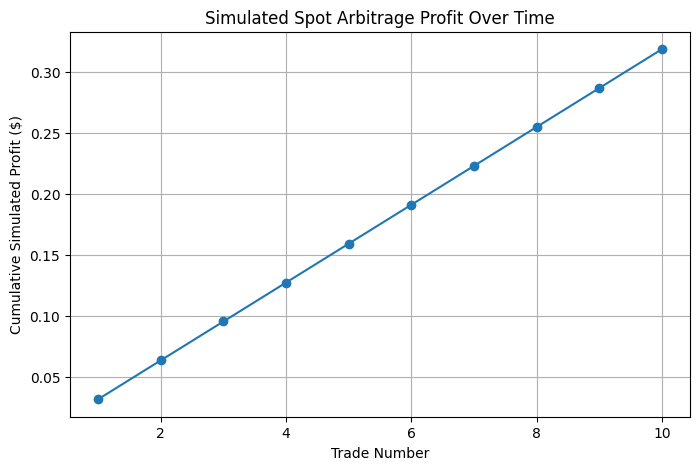

In [3]:
# --- Load API Keys from JSON (for fetching prices only) ---
with open("keys.json", "r") as file:
    keys = json.load(file)

# --- Connect to Binance & Bybit Spot Trading (Read-Only for Paper Trading) ---
binance = ccxt.binance({'options': {'defaultType': 'spot'}, 'enableRateLimit': True})
bybit = ccxt.bybit({'options': {'defaultType': 'spot'}})

print("✅ Connected to Binance & Bybit (Paper Trading Mode)")

# --- Trading Parameters ---
initial_balance = 10000  # USD balance
trade_amount = 10  # Simulated trade size in USD
spread_threshold = 0.5  # Minimum spread for arbitrage
trade_fee = 0.001  # 0.1% per trade (simulated)
min_trade_time = 0.2  # Min execution time (sec)
max_trade_time = 0.5  # Max execution time (sec)

# --- Simulated Account Balances ---
balance_binance = initial_balance / 2
balance_bybit = initial_balance / 2
profit = 0
num_trades = 0
trade_log = []

# --- Fetch Spot Prices ---
def get_spot_price(exchange, symbol="SLP/USDT"):
    try:
        ticker = exchange.fetch_ticker(symbol)
        return ticker["last"]
    except Exception as e:
        print(f"⚠️ Error fetching price from {exchange.name}: {e}")
        return None

# --- Simulated Arbitrage Trading ---
for _ in range(10):  # Run arbitrage 10 times (Adjust as needed)
    binance_price = get_spot_price(binance)
    bybit_price = get_spot_price(bybit)

    if binance_price is None or bybit_price is None:
        continue

    spread = abs(binance_price - bybit_price)
    clear_output(wait=True)
    print(f"📊 Binance: ${binance_price:.2f} | Bybit: ${bybit_price:.2f} | Spread: ${spread:.2f}")

    if binance_price < bybit_price:
        buy_exchange, sell_exchange = "Binance", "Bybit"
        buy_price, sell_price = binance_price, bybit_price
        if balance_binance < trade_amount:
            print("⚠️ Not enough balance on Binance for trade.")
            continue
        balance_binance -= trade_amount
        balance_bybit += trade_amount
    else:
        buy_exchange, sell_exchange = "Bybit", "Binance"
        buy_price, sell_price = bybit_price, binance_price
        if balance_bybit < trade_amount:
            print("⚠️ Not enough balance on Bybit for trade.")
            continue
        balance_bybit -= trade_amount
        balance_binance += trade_amount

    trade_execution_time = random.uniform(min_trade_time, max_trade_time)
    print(f"⏳ Simulating Arbitrage Trade... (Time: {trade_execution_time:.2f}s)")
    time.sleep(trade_execution_time)

    # ✅ Calculate simulated profit
    fee_cost = trade_amount * (trade_fee * 2)  # Two trades (Buy + Sell)
    trade_profit = ((sell_price - buy_price) / buy_price) * trade_amount - fee_cost
    profit += trade_profit
    num_trades += 1

    print(f"✅ Trade {num_trades}: Bought on {buy_exchange} (${buy_price:.2f}), Sold on {sell_exchange} (${sell_price:.2f})")
    print(f"💰 Simulated Profit: ${trade_profit:.2f} | Total Profit: ${profit:.2f} | Fees: ${fee_cost:.2f}\n")

    trade_log.append([num_trades, buy_exchange, sell_exchange, buy_price, sell_price, spread, trade_profit, fee_cost, trade_execution_time])

# --- Display Simulated Trade History ---
trade_df = pd.DataFrame(trade_log, columns=["Trade #", "Buy Exchange", "Sell Exchange", "Buy Price", "Sell Price", "Spread", "Profit", "Fees", "Trade Time"])
display(trade_df)

# --- Plot Profit Over Time ---
plt.figure(figsize=(8,5))
plt.plot(trade_df["Trade #"], trade_df["Profit"].cumsum(), marker='o', linestyle='-')
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Simulated Profit ($)")
plt.title("Simulated Spot Arbitrage Profit Over Time")
plt.grid(True)
plt.show()



In [4]:
import ccxt

# Connect to Binance & Bybit Spot
binance = ccxt.binance({'options': {'defaultType': 'spot'}})
bybit = ccxt.bybit({'options': {'defaultType': 'spot'}})

# Fetch available symbols
binance_symbols = binance.load_markets().keys()
bybit_symbols = bybit.load_markets().keys()

# Find common symbols
common_symbols = list(set(binance_symbols) & set(bybit_symbols))
print(f"✅ Found {len(common_symbols)} common symbols:")
print(common_symbols[:20])  # Show the first 20 symbols


✅ Found 687 common symbols:
['ETH/USD:ETH-250328', 'RENDER/USDT:USDT', 'ARB/USDC', 'NOT/USDT', 'VANRY/USDT', 'MINA/USDT', 'ORBS/USDT:USDT', 'SNT/USDT:USDT', 'BTC/USDT:USDT', 'APE/USDT:USDT', 'DYM/USDT', 'APT/USDC', 'SWARMS/USDT:USDT', 'SUI/USDT:USDT', 'FXS/USDT', 'SEI/USDC', 'FIL/USDT:USDT', 'STPT/USDT:USDT', 'COOKIE/USDT', 'HBAR/USDT:USDT']


In [5]:
def find_best_arbitrage():
    spread_data = []
    
    for symbol in common_symbols[:50]:  # Check the first 50 symbols
        try:
            binance_price = binance.fetch_ticker(symbol)["last"]
            bybit_price = bybit.fetch_ticker(symbol)["last"]

            if binance_price and bybit_price:
                spread = abs(binance_price - bybit_price)
                spread_percentage = (spread / min(binance_price, bybit_price)) * 100
                spread_data.append((symbol, spread_percentage))
        except:
            continue  # Skip symbols with errors

    # Sort by highest spread
    spread_data.sort(key=lambda x: x[1], reverse=True)
    best_symbol = spread_data[0] if spread_data else None
    
    print("🔍 Best Arbitrage Opportunity:")
    print(f"Symbol: {best_symbol[0]} | Spread: {best_symbol[1]:.2f}%") if best_symbol else print("No significant arbitrage found.")

# Run it
find_best_arbitrage()


🔍 Best Arbitrage Opportunity:
Symbol: ORBS/USDT:USDT | Spread: 69.43%
